# VLM-RAG Test Notebook

## System Components:
1. **Vector Database** - ChromaDB for storing past interactions
2. **Visual Interpreter** - OpenRouter API for vision models 
3. **Validation Judge** - LLM judge for comparing responses

## Research Questions:
1. To what degree do BLV users visual needs change across similar visual contexts?
2. Can we leverage past users interactions to provide more relevant future visual interpretations?


In [61]:
# Setup and imports
import chromadb
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO

# Check ChromaDB version
print(f"ChromaDB version: {chromadb.__version__}")

import sys
import os
from dotenv import load_dotenv
load_dotenv()

# Add the parent directory to path so we can import our modules
sys.path.append('..')

# Now we can import from the src directory
from src.vector_db import SimpleVectorDB

# Step 1: Initialize the Vector Database
print("🚀 Initializing Vector Database for Image Embeddings...")

# Initialize the simplified vector database
db = SimpleVectorDB()

print("\n✅ Vector Database initialized!")



ChromaDB version: 1.0.15
🚀 Initializing Vector Database for Image Embeddings...
Vector DB initialized at: ./data/chroma_db
Persistence enabled: Data will be saved to disk

✅ Vector Database initialized!


# Load Collection or Create a new One

In [62]:

print("🗄️ Creating fresh collection for this experiment...")

experiment_name = "vizwiz_experiment_v2"

# Create new database instance with fresh collection
db.use_collection("vizwiz_500_sample_cosine", "500 random VizWiz samples using cosine normalized similarity")
# Check it's empty
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

print("✅ Fresh collection created for controlled experiment!")


🗄️ Creating fresh collection for this experiment...
Collection 'vizwiz_500_sample_cosine' ready
Now using collection: vizwiz_500_sample_cosine
📊 Fresh collection stats: {'total_images': 500, 'collection_name': 'vizwiz_500_sample_cosine', 'persisted': True}
✅ Fresh collection created for controlled experiment!


# Load 500 entries from vizwiz

In [35]:
# Step 2: Load VizWiz data using pre-computed embeddings
import json
import pandas as pd
from IPython.display import display
from pathlib import Path

print("📝 Loading VizWiz data using pre-computed embeddings...")

# Load the original JSON data
data_path = Path('./data/original/all.json')
try:
    with open(data_path, 'r') as f:
        all_data = json.load(f)
    print(f"✅ Loaded {len(all_data)} total entries from all.json")
except FileNotFoundError:
    print(f"❌ File '{data_path}' not found!")
    print("Please make sure you have the VizWiz data in the correct location.")
    all_data = {}

# Load pre-computed embeddings to get the IDs we should use
embeddings_path = Path('./data/embeddings/lf_vqa_db_embeddings_cohere.json')
try:
    with open(embeddings_path, 'r') as f:
        embeddings_data = json.load(f)
    print(f"✅ Loaded pre-computed embeddings from {embeddings_path}")
    
    # Extract IDs and embeddings from the embeddings data
    embedding_ids = []
    embeddings_dict = {}
    if 'items' in embeddings_data:
        for item in embeddings_data['items']:
            if 'id' in item and 'embedding' in item:
                item_id = str(item.get('id'))
                embedding_ids.append(item_id)
                embeddings_dict[item_id] = item['embedding']
    
    print(f"📊 Found {len(embedding_ids)} IDs and embeddings in embeddings file")
    
except FileNotFoundError:
    print(f"❌ Embeddings file '{embeddings_path}' not found!")
    print("Please make sure you have the pre-computed embeddings in the correct location.")
    embedding_ids = []
    embeddings_dict = {}

# Check if collection already has data
stats = db.get_collection_stats()
if stats.get("total_images", 0) > 0:
    print(f"📊 Found existing collection with {stats['total_images']} entries")
    
    # Get all IDs from the existing collection
    results = db.current_collection.get()
    existing_ids = results["ids"]
    print(f"🔄 Using {len(existing_ids)} existing IDs from collection")
    
    # Extract sample data from all_data using existing IDs
    sample_data = {}
    for key in existing_ids:
        if key in all_data:
            sample_data[key] = all_data[key]
    
    print(f"✅ Extracted {len(sample_data)} entries from existing collection")
else:
    # Use IDs from pre-computed embeddings
    if embedding_ids and all_data:
        print(f"🎯 Using {len(embedding_ids)} IDs from pre-computed embeddings")
        print(f"Sample IDs: {embedding_ids[:10]}...")  # Show first 10
        
        # Extract sample data using embedding IDs
        sample_data = {}
        for key in embedding_ids:
            if key in all_data:
                sample_data[key] = all_data[key].copy()  # Copy the original data
                # Add the corresponding embedding from embeddings_dict
                if key in embeddings_dict:
                    sample_data[key]['embedding'] = embeddings_dict[key]
        
        print(f"✅ Extracted {len(sample_data)} entries for processing")
    else:
        sample_data = {}
        print("⚠️ No embedding IDs or data loaded - will use dummy data for testing")

# Show example of what we extracted
if sample_data:
    example_key = list(sample_data.keys())[0]
    example_entry = sample_data[example_key]
    print(f"\n📋 Example entry (ID: {example_key}):")
    for field in ['question', 'answerability', 'question_type', 'crowd_majority', 'image_url']:
        if field in example_entry:
            print(f"  {field}: {example_entry[field]}")
    
    # Display first 10 rows as a table
    print("\n📊 First 10 sampled entries:")
    sample_rows = []
    for i, (key, data) in enumerate(list(sample_data.items())[:10]):
        sample_rows.append({
            'ID': key,
            'Question': data.get('question', 'N/A'),
            'Answerability': data.get('answerability', 'N/A'),
            'Question Type': data.get('question_type', 'N/A'),
            'Crowd Majority': data.get('crowd_majority', 'N/A'),
            'Image URL': data.get('image_url', 'N/A'),
            'Embedding': data.get('embedding', 'N/A')
        })
    
    # Create and display DataFrame
    df = pd.DataFrame(sample_rows)
    display(df)


📝 Loading VizWiz data using pre-computed embeddings...
✅ Loaded 600 total entries from all.json
✅ Loaded pre-computed embeddings from data\embeddings\lf_vqa_db_embeddings_cohere.json
📊 Found 500 IDs and embeddings in embeddings file
🎯 Using 500 IDs from pre-computed embeddings
Sample IDs: ['596', '39', '416', '56', '31', '230', '372', '433', '308', '377']...
✅ Extracted 500 entries for processing

📋 Example entry (ID: 596):
  question: what is the scientific name of this leaf?
  answerability: unanswerable
  question_type: Others
  crowd_majority: unanswerable
  image_url: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_val_00002308.jpg

📊 First 10 sampled entries:


,ID,Question,Answerability,Question Type,Crowd Majority,Image URL,Embedding
0,596,what is the scientific name of this leaf?,unanswerable,Others,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[0.0079345703125, -0.01220703125, -0.033935546..."
1,39,What is this bottle?,answerable,Identification,febreze,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[0.0174560546875, 0.00191497802734375, -0.0162..."
2,416,For how long do I cook this in the microwave?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.0517578125, -0.0400390625, -0.0400390625, ..."
3,56,What is this?,answerable,Identification,2 water bottles,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.00860595703125, -0.0234375, -0.02526855468..."
4,31,What is this?,answerable,Identification,jambalaya mix,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.06982421875, -0.01495361328125, 0.02209472..."
5,230,What color is this highlighter?,answerable,Description,yellow,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.0162353515625, -0.0245361328125, -0.007873..."
6,372,when did this expire?,unanswerable,Reading,unanswerable,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.00494384765625, -0.0037689208984375, 0.006..."
7,433,"What time does it say, on my set top box? Than...",answerable,Reading,12:10,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[0.00665283203125, -0.0147705078125, -0.000888..."
8,308,What does the label say?,answerable,Reading,chap stick,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.00921630859375, -0.01226806640625, -0.0055..."
9,377,What's the warning label?,answerable,Reading,may cause drowsiness,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,"[-0.01251220703125, 0.0029754638671875, -0.009..."


# Check Collection Currently loaded

In [63]:
stats = db.get_collection_stats()
print(f"📊 Fresh collection stats: {stats}")

📊 Fresh collection stats: {'total_images': 500, 'collection_name': 'vizwiz_500_sample_cosine', 'persisted': True}


## Test embedding functions

In [7]:
# Extract and print the first item from sample_data with focus on image_url
first_item = list(sample_data.items())[:1]
if first_item:
    entry_id, entry_data = first_item[0]
    image_url = entry_data.get('image_url', 'No image URL found')
    print(f"Entry ID: {entry_id}, Image URL: {image_url}")

    print("test embedding generation")
    print("embedding generated", cohere_generate_image_embedding(image_url))
else:
    print("No data found in sample_data")

Entry ID: 126, Image URL: https://vizwiz.cs.colorado.edu/VizWiz_visualization_img/VizWiz_train_00019874.jpg
test embedding generation
MBKKF3QGUZWfr6O02WQfoclbqv6URt20FHbeAHCu
embedding generated [[0.01373291, -0.025146484, 0.02368164, -0.036621094, 0.08544922, 0.018432617, 0.00680542, 0.006866455, -0.03857422, -0.03112793, -0.01928711, 0.08105469, -0.015319824, -0.013244629, 0.010314941, 0.048583984, 0.03125, 0.015075684, 0.020874023, -0.014770508, -0.015075684, -0.010070801, 0.045898438, 0.02722168, -0.028076172, -0.027832031, 0.030639648, 0.020385742, 0.02746582, 0.025512695, -0.036621094, -0.003616333, -0.0006828308, -0.048339844, -0.03125, 0.0017776489, 0.03564453, 0.0013198853, 0.020141602, -0.024169922, 0.028442383, -0.011657715, 0.01184082, 0.010192871, 0.027832031, 0.03930664, 0.021850586, 0.017822266, -0.041259766, -0.019897461, -0.027954102, 0.05102539, -0.0006980896, -0.018676758, -0.009277344, 0.019042969, 0.021362305, 0.008117676, 0.0012435913, -0.022460938, 0.011230469, 0

## Upload data into collection

In [44]:

# Import numpy for vector normalization
import numpy as np

# Step 3: Process sample data and add to vector database
print("🔍 Processing sample data and adding to vector database...")

# Check current stats
stats = db.get_collection_stats()
print(f"Current database stats: {stats}")

# Process the sample data if we have it
if sample_data:
    print(f"\n📊 Processing {len(sample_data)} VizWiz entries...")
    
    added_count = 0
    for entry_id, entry_data in list(sample_data.items())[:]:  # Process first 2 for demo
        try:
            image_url = entry_data.get('image_url', '')
            # Generate embedding and normalize it for cosine similarity
            embedding_vector = entry_data.get('embedding', [])
            # Normalize the embedding vector for cosine similarity
            embedding = np.array(embedding_vector)
            embedding = embedding / np.linalg.norm(embedding)
            
            # Extract required fields from VizWiz data
            question = entry_data.get('question', 'No question provided')
            answerability = entry_data.get('answerability', 'unknown')
            question_type = entry_data.get('question_type', 'unknown')
            crowd_answers = entry_data.get('crowd_answers', [])
            crowd_majority = entry_data.get('crowd_majority', 'unknown')
            
            
            # Add to vector database
            db.add_image_embedding(
                embedding_id=entry_id,
                image_embedding=embedding,
                question=question,
                answerability=answerability,
                question_type=question_type,
                image_url=image_url,
                crowd_answers=crowd_answers,
                crowd_majority=crowd_majority
            )
            
            added_count += 1
            
        except Exception as e:
            print(f"❌ Error processing entry {entry_id}: {e}")
    
    print(f"✅ Successfully added {added_count} entries to vector database")
    
# Check updated stats
stats = db.get_collection_stats()
print(f"\n📊 Updated database stats: {stats}")


🔍 Processing sample data and adding to vector database...
Current database stats: {'total_images': 0, 'collection_name': 'vizwiz_500_sample_cosine_normalized', 'persisted': True}

📊 Processing 500 VizWiz entries...
Added embedding 596 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 39 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 416 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 56 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 31 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 230 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 372 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 433 to collection 'vizwiz_500_sample_cosine_normalized' (persisted to disk)
Added embedding 308 to collection 'vizwiz_500_sample

# Testing Search


🚀 Testing COHERE Similarity Search with a RANDOM query
📁 Loaded COHERE validation file './data/embeddings/lf_vqa_validation_embeddings_cohere.json' with 100 embeddings

🎯 Selected random validation image for query:


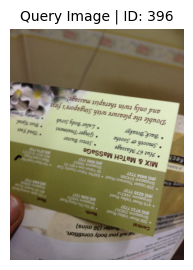

   Query Question: any phone number written here.

------------------------------ SEARCH RESULTS ------------------------------


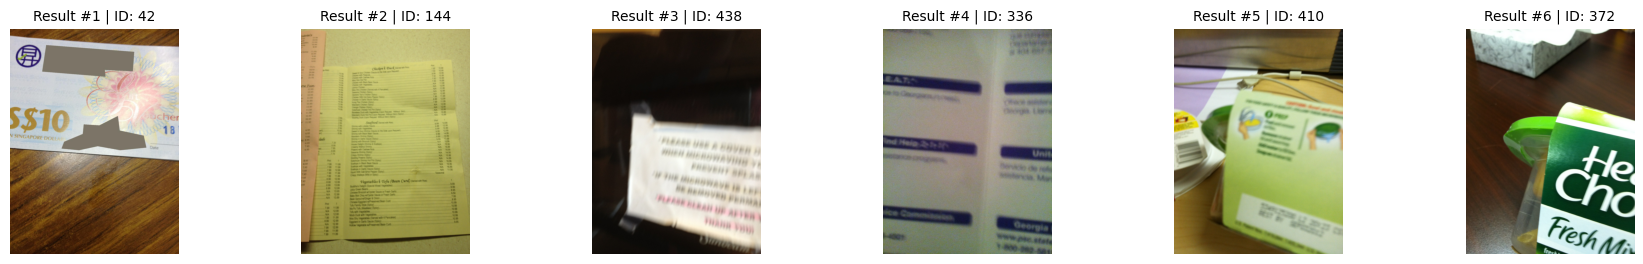

  Result #1 Details:
     Question: Is this a voucher?
     Answerability: answerable
     Question Type: Identification
     Crowd Majority: yes
     Distance: 0.5911

  Result #2 Details:
     Question: What is this?
     Answerability: answerable
     Question Type: Identification
     Crowd Majority: menu
     Distance: 0.5970

  Result #3 Details:
     Question: What does this sign say?
     Answerability: unanswerable
     Question Type: Reading
     Crowd Majority: unanswerable
     Distance: 0.6246

  Result #4 Details:
     Question: What's on this document?
     Answerability: unanswerable
     Question Type: Reading
     Crowd Majority: unanswerable
     Distance: 0.6337

  Result #5 Details:
     Question: When will this product expire?
     Answerability: unanswerable
     Question Type: Reading
     Crowd Majority: unanswerable
     Distance: 0.6359

  Result #6 Details:
     Question: when did this expire?
     Answerability: unanswerable
     Question Type: Reading
    

In [ ]:
import json
import random
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

# --- Las mismas funciones de ayuda que definimos para el script de OpenCLIP ---
# Las incluimos aquí para que este script sea autocontenido.

def show_query_image(url, title=""):
    """Downloads and displays a single image with a smaller size."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        img = Image.open(BytesIO(response.content))
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(title, fontsize=10)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"--- Could not display image from {url}: {e} ---")

def show_results_horizontally(results_list):
    """
    Downloads and displays a list of result images in a single row (smaller),
    with metadata printed below each image.
    """
    num_results = len(results_list)
    if num_results == 0:
        return
    fig, axes = plt.subplots(1, num_results, figsize=(3 * num_results, 3))
    if num_results == 1:
        axes = [axes]

    print("\n" + "-"*30 + " SEARCH RESULTS " + "-"*30)
    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        result_id = result_data.get('id', 'N/A')
        image_url = metadata.get('image_url', '')
        ax = axes[i]
        
        if image_url:
            try:
                response = requests.get(image_url)
                response.raise_for_status()
                img = Image.open(BytesIO(response.content))
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, f"Image not found:\n{e}", ha='center', va='center', fontsize=8)
        else:
            ax.text(0.5, 0.5, "No Image URL", ha='center', va='center', fontsize=8)

        ax.set_title(f"Result #{i+1} | ID: {result_id}", fontsize=10)
        ax.axis('off')

    plt.tight_layout(pad=2.0)
    plt.show()

    for i, result_data in enumerate(results_list):
        metadata = result_data.get('metadata', {})
        distance = result_data.get('distance', 0.0)
        print(f"  Result #{i+1} Details:")
        print(f"     Question: {metadata.get('question', 'N/A')}")
        print(f"     Answerability: {metadata.get('answerability', 'N/A')}")
        print(f"     Question Type: {metadata.get('question_type', 'N/A')}")
        print(f"     Crowd Majority: {metadata.get('crowd_majority', 'N/A')}")
        print(f"     Distance: {distance:.4f}\n")


# ==============================================================================
# Bloque Principal de Búsqueda Aleatoria de COHERE (Actualizado)
# ==============================================================================

print("\n" + "="*80)
print("🚀 Testing COHERE Similarity Search with a RANDOM query")
print("="*80)

try:
    # Apunta al archivo de validación de COHERE
    validation_file = "./data/embeddings/lf_vqa_validation_embeddings_cohere.json"
    with open(validation_file, 'r') as f:
        validation_data = json.load(f)
    
    print(f"📁 Loaded COHERE validation file '{validation_file}' with {validation_data['count']} embeddings")
    
    # Selecciona un item de validación al azar
    random_validation_item = validation_data['items'][0]
    query_embedding = random_validation_item['embedding'][0]
    query_metadata = random_validation_item['metadata']
    query_id = random_validation_item['id']
    
    # Muestra la imagen de consulta y su pregunta
    print(f"\n🎯 Selected random validation image for query:")
    query_image_url = query_metadata.get('image_url')
    show_query_image(query_image_url, title=f"Query Image | ID: {query_id}")
    print(f"   Query Question: {query_metadata.get('question', 'N/A')}")
    
    # Realiza la búsqueda
    results = db.search_similar_images(query_embedding, n_results=6)
    
    # Filtra el resultado si coincide con el ID de la consulta
    filtered_results = [res for res in results['similar_images'] if res.get('id') != query_id]
    final_results_to_display = filtered_results

    # Muestra los resultados con el ploteo horizontal
    if not final_results_to_display:
        print("\n   No other similar images were found in the database.")
    else:
        # <<< CAMBIO: Se llama a la nueva función de ploteo horizontal >>>
        show_results_horizontally(final_results_to_display)

except FileNotFoundError:
    print(f"❌ COHERE validation embeddings file not found: {validation_file}")
    print("Please make sure the Cohere validation embeddings have been generated first.")
except Exception as e:
    print(f"❌ An error occurred during the Cohere test: {e}")

## Define embedding generation functions

In [ ]:

from chromadb.utils import embedding_functions
import cohere
import requests
import base64
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

def cohere_generate_image_embedding(image_path):
    """
    Generate embeddings for an image using Cohere's multimodal embedding model
    
    Args:
        image_path: Path to the image file
        
    Returns:
        List of float embeddings for the image
    """
    # Initialize Cohere client with API key from environment variables
    co = cohere.ClientV2(api_key=os.getenv("COHERE_API_KEY"))
    # Read image file or download from URL
    if image_path.startswith(('http://', 'https://')):
        image = requests.get(image_path)
        image_content = image.content
        content_type = image.headers.get("Content-Type", "image/jpeg")
    else:
        with open(image_path, 'rb') as f:
            image_content = f.read()
        content_type = "image/jpeg"  # Default assumption
    
    # Convert image to base64 format
    stringified_buffer = base64.b64encode(image_content).decode("utf-8")
    image_base64 = f"data:{content_type};base64,{stringified_buffer}"
    
    # Generate embedding using Cohere's API
    response = co.embed(
        model="embed-v4.0",
        input_type="image",
        embedding_types=["float"],
        images=[image_base64],
    )
    
    # Return the embedding vector
    return response.embeddings.float


# Precalculate Embeddings and Store

In [19]:
# Generate and save embeddings for validation images
import json
import os
from pathlib import Path

print("\n💾 Generating and saving validation embeddings to disk...")

# Create embeddings directory
os.makedirs("../data/embeddings", exist_ok=True)

# Prepare filename for validation embeddings
validation_filename = "./data/embeddings/lf_vqa_validation_embeddings.json"

# Generate and save validation embeddings
try:
    validation_embeddings = []
    
    print(f"Generating embeddings for {len(validation_sample)} validation images...")
    
    # Extract validation entries from all_data using validation_sample IDs
    for val_id in validation_sample:
        if val_id in all_data:  # Only check if ID exists in original data
            val_entry = all_data[val_id]
            image_url = val_entry.get('image_url', '')
            
            if image_url:
                # Generate embedding for this validation image using original data
                embedding = cohere_generate_image_embedding(image_url)
                
                validation_embeddings.append({
                    "id": val_id,
                    "embedding": embedding,
                    "metadata": {
                        "question": val_entry.get('question', ''),
                        "answerability": val_entry.get('answerability', ''),
                        "question_type": val_entry.get('question_type', ''),
                        "crowd_majority": val_entry.get('crowd_majority', ''),
                        "image_url": image_url
                    }
                })
                print(f"  Generated embedding for validation ID: {val_id} (from original data)")
            else:
                print(f"  ⚠️ No image URL found for validation ID: {val_id}")
        else:
            print(f"  ⚠️ Validation ID {val_id} not found in original data")
    
    # Save validation embeddings to file
    validation_data = {
        "count": len(validation_embeddings),
        "items": validation_embeddings,
    }
    
    with open(validation_filename, 'w') as f:
        json.dump(validation_data, f)
    
    print(f"✅ Saved {len(validation_embeddings)} validation embeddings to {validation_filename}")
    print(f"📊 Success rate: {len(validation_embeddings)}/{len(validation_sample)} validation images processed")
except Exception as e:
    print(f"❌ Error generating validation embeddings: {str(e)}")



💾 Generating and saving validation embeddings to disk...
Generating embeddings for 100 validation images...
  Generated embedding for validation ID: 396 (from original data)
  Generated embedding for validation ID: 60 (from original data)
  Generated embedding for validation ID: 519 (from original data)
  Generated embedding for validation ID: 77 (from original data)
  Generated embedding for validation ID: 391 (from original data)
  Generated embedding for validation ID: 583 (from original data)
  Generated embedding for validation ID: 41 (from original data)
  Generated embedding for validation ID: 453 (from original data)
  Generated embedding for validation ID: 35 (from original data)
  Generated embedding for validation ID: 464 (from original data)
  Generated embedding for validation ID: 61 (from original data)
  Generated embedding for validation ID: 305 (from original data)
  Generated embedding for validation ID: 74 (from original data)
  Generated embedding for validation ID